# Simulate a cave emptiing using bernouilli equation, and the darcy-Weissbach

This Jupyter notebook simulates the emptying of a cave through a breach using fluid mechanics principles, including the Bernoulli equation and the Darcy-Weisbach and Poiseuille laws. It generates random cave and breach parameters, calculates maximum flow rates, visualizes distributions, and performs time-dependent simulations of cave drainage. The notebook also includes iterative friction factor calculations and statistical analysis of flow rates over multiple scenarios.

The conceptual model is a cave emptying, in the tunnel, with a hit in a given distance. 

The flow is calculated using the Bernouilli equation, which is simplified to:
    Equation : Q = A * sqrt(2 * g * h)

with Q the flow, A the Area of the outflow section, g the gravity and h the water height in the cave. 
Since the main focus in on the maximum flow and not on the time, we can only consider the cave height and not all its geometry.

In [6]:
def conduit_diameter(n=1):
    """
    Generate random conduit diameters based on interpolated pipe area distribution.

    Args:
        n (int): Number of diameters to generate.

    Returns:
        np.ndarray: Array of pipe diameters.
    """
    rand = np.random.random(n)
    pipe_area = pipe_function(rand)
    pipe_diameter = 2 * np.sqrt(pipe_area / math.pi)
    return pipe_diameter

def conduit_length(n=1):
    """
    Generate random conduit lengths up to 20 meters.

    Args:
        n (int): Number of lengths to generate.

    Returns:
        np.ndarray: Array of pipe lengths.
    """
    rand = np.random.random(n)
    pipe_l = rand * 20
    return pipe_l

def Reynolds(v, diameter):
    """
    Calculate Reynolds number.

    Args:
        v (float): Velocity [m/s].
        diameter (float): Pipe diameter [m].

    Returns:
        float: Reynolds number.
    """
    Re = (v * diameter * 1000) / 1e-3
    return Re

def Churchill(Re, Rr):
    """
    Calculate friction factor using Churchill's equation.

    Args:
        Re (float): Reynolds number.
        Rr (float): Relative roughness.

    Returns:
        float: Friction factor.
    """
    A = (-2.457 * np.log((7.0 / Re) ** 0.9 + 0.27 * Rr)) ** 16
    B = (37530.0 / Re) ** 16
    f = 8.0 * ((8.0 / Re) ** 12 + (A + B) ** (-1.5)) ** (1 / 12)
    return f

def Darcy_Weisbach(dh, dx, lamda, diameter):
    """
    Calculate flow using Darcy-Weisbach equation.

    Args:
        dh (float): Head difference [m].
        dx (float): Pipe length [m].
        lamda (float): Friction factor.
        diameter (float): Pipe diameter [m].

    Returns:
        float: Flow rate [m^3/s].
    """
    Q = math.pi * (diameter / 2) ** 2 * 2 * math.sqrt(9.81 * diameter / 2) / math.sqrt(lamda) * math.sqrt(dh / dx)
    return Q

def reynolds_ph(R, Q, mu=1.30E-3, rho=999.7):
    """
    Calculate Reynolds number for given radius and flow.

    Args:
        R (float): Pipe radius [m].
        Q (float): Flow rate [m^3/s].
        mu (float): Dynamic viscosity [Pa.s].
        rho (float): Density [kg/m^3].

    Returns:
        float: Reynolds number.
    """
    V = Q / (np.pi * R ** 2)
    Re = V * rho * 2.0 * R / mu
    return Re

def Poiseuille(dh, dx, diameter, rho=999.7, mu=1.30E-3):
    """
    Calculate flow using Poiseuille's law.

    Args:
        dh (float): Head difference [m].
        dx (float): Pipe length [m].
        diameter (float): Pipe diameter [m].
        rho (float): Density [kg/m^3].
        mu (float): Dynamic viscosity [Pa.s].

    Returns:
        float: Flow rate [m^3/s].
    """
    Q = math.pi * rho * 9.81 * (diameter / 2) ** 4 / 8 / mu * dh / dx
    return Q

g = 9.81 # Acceleration of gravity [m/s2]

def f_karman(Rr):
    """
    Computes the friction factor for a given rugosity assuming that
    the Reynolds number is very large
    """
    return 1/(2*np.log10(Rr/3.7))**2


def flux_from_cavity(h,d,L,Rr,verbose=False,rho=998,mu=1.3e-3, cs = 0.5):
    """
    Computes the flux from a cavity through a karst conduit to a tunnel
    using Bernoulli and Darcy-Weisbach equations

    input:

     h = height of the water level in cavity above the tunnel in [m]
     d = diameter of the conduits in [m]
     L = length of the horizontal condtuit in [m]
     Rr = rugosity of the conduits [unitless ratio] (should be < 0.1)

     verbose = a boolean flag, if equals True it prints intermediate results
     rho, mu = density and viscosity
     cs = singular head losses (by default only entrance into conduit)

    output:

     q = flux in [m3/s]

    method:
     a non linear equation solver is used

     two coupled equations are considered
     - one coming from Bernoulli energy balance and Darcy Weisbach
     - the Colenbrook equation to determine the friction factor

     the non linear solver needs an initial solution, therefore solving
     the problems requires two steps:
      1/ we get an approximate solution assuming that reynolds numbers is very high
      2/ we use this as a starting point for the non linear solver

    """

    # Compute approximate solution
    f = f_karman(Rr) # friction factor for high Reynolds number (Karman equation)
    v = np.sqrt( 2*g*h / (1 + cs + f*L/d) ) # Solving Bernoulli for velocity

    # Define the system of non linear equations to solve
    def flowproblem(x):
        """
        Takes as an input the two unknowns:
         x[0] is the velocity, and x[1] the friction factor

        Returns the values computed for the two equations to solve. These values
        should be equal to zero.
        """

        # This is just to improve readibility
        v,f = x[0], x[1] # flow velocity [m/s] and friction factor

        # Initialize the values returned by the function
        y = np.zeros(2)

        # Bernoulli equation: y[0] should be equal to 0 to ensure energy balance
        y[0] = v**2 * (1+ cs + f*L/d)  - 2*g*h

        # Colebrook equation written as a function of f and v
        # The Reynolds number is written explicitly
        y[1] = 1/np.sqrt(f) + 2*np.log10(Rr/3.7 + 2.51*mu/(v*rho*d*np.sqrt(f)))

        return y

    # Solve the non linear problem
    x = fsolve( flowproblem, [v,f] )
    v,f = x[0], x[1]

    # Compute the flux in [m3/s]
    q = np.pi * (d/2)**2 * v

    # To print detailed results
    if verbose:
        y = flowproblem(x) # For convergence check
        print('input:')
        print('------')
        print(' total height:',h,'[m]')
        print(' diameter:',d,'[m]')
        print(' length:',L,'[m]')
        print(' rugosity:',Rr,'[unitless]')
        print(' mu/rho:',mu/rho,'[m2*s]')
        print(' cs:',cs,'[-]')
        print('output:')
        print('-------')
        print(' velocity:',v,'[m/s]')
        print(' flux:',q,'[m3/s]')
        print(' friction factor:',f,'[unitless]')
        print(' Reynolds number:',v*rho*d/mu,'[unitless]')
        print('convergence check:')
        print('-------')
        print(' Bernoulli equation:',y[0])
        print(' Colenbrook equation:',y[1])

    return q

In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from scipy import stats
from scipy import interpolate

Read Area of conduits

In [4]:
data_conduit = np.genfromtxt('Size_conduits.csv', delimiter=';')
quantile = data_conduit[:,0]
size = data_conduit[:,1]
pipe_function = interpolate.interp1d(quantile,size)

Text(0.5, 1.0, 'Distribution of conduits')

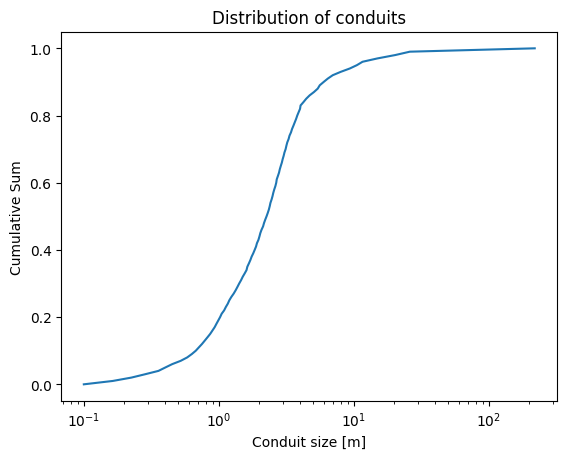

In [5]:
plt.plot(size,quantile)
plt.xscale('log')
plt.xlabel('Conduit size [m]')
plt.ylabel('Cumulative Sum')
plt.title('Distribution of conduits')

In [8]:
# Test  functions
print("Test conduit_diameter:", conduit_diameter())
print("Test conduit_length:", conduit_length())
print("Test Reynolds:", Reynolds(2.0, 0.5))
print("Test Churchill:", Churchill(10000, 0.05))
print("Test Darcy_Weisbach:", Darcy_Weisbach(5, 10, 0.02, 0.5))
print("Test reynolds_ph:", reynolds_ph(0.25, 1.0))
print("Test Poiseuille:", Poiseuille(5, 10, 0.5))

Test conduit_diameter: [0.74006053]
Test conduit_length: [10.22508213]
Test Reynolds: 1000000.0
Test Churchill: 0.07500942603348314
Test Darcy_Weisbach: 3.0749240840267897
Test reynolds_ph: 1958242.4198026806
Test Poiseuille: 5786.091162961306


# Bernouilli

In [47]:
n_sim = 20
cave_max_height = 20
breach_bounds = [0.1,2]

In [31]:
cave_height     = np.random.random((n_sim,)) * cave_max_height #will implement ditrib
breach_diameter = conduit_diameter(n_sim)
Areas = math.pi * np.power(breach_diameter/2,2)
g = 9.81
max_Q_nopipe = Areas*np.sqrt(2*g*cave_height)
reynolds_ph(breach_diameter/2,max_Q_nopipe)

array([54114899.41518229, 33743335.65064978, 20686078.20423088,
       14218821.35222891,  4577537.96510915, 12148616.66017613,
       30665667.28547304,  5267530.25768688, 20773103.83682759,
       10074307.00800367, 23223136.40675402, 17122267.14582459,
       25302520.94900637,  6920293.04149556, 14703595.85248652,
       20046267.7347101 ,  7906630.5566367 ,  5062180.10250869,
        5760643.56841129,  1777659.9602126 ])

Text(0.5, 1.0, 'No pipe')

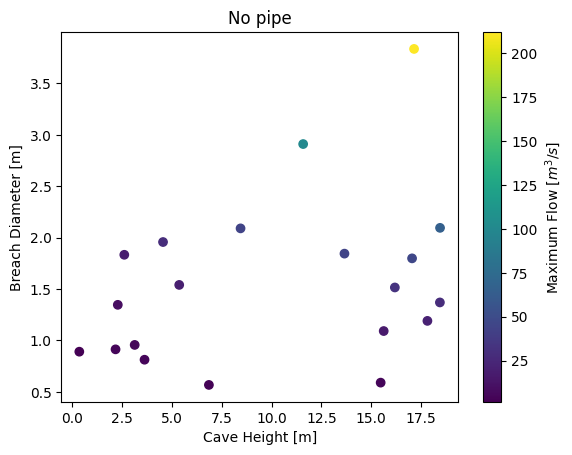

In [32]:
plt.scatter(cave_height,breach_diameter,c=max_Q_nopipe)
plt.xlabel('Cave Height [m]')
plt.ylabel('Breach Diameter [m]')
cbar = plt.colorbar()
cbar.ax.set_ylabel('Maximum Flow [$m^{3} / s$]')
plt.title('No pipe')

<a list of 6 text.Text objects>

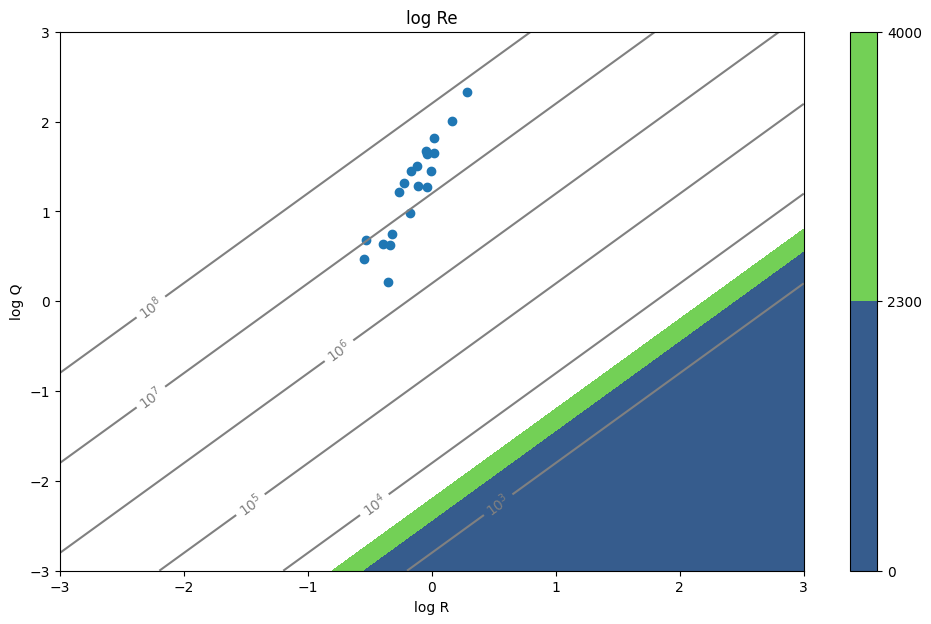

In [34]:
R = np.logspace(-3,3)
Q = np.logspace(-3,3)
rr,qq = np.meshgrid( R, Q )
re = np.ones( [len(Q),len(R)] )

for i in range( len(Q)):
    re[i,:] = reynolds_ph( R,Q[i], mu=1.01e-3, rho=998 )


fig, ax = plt.subplots(figsize=(12,7))
Cs = ax.contour(np.log10(rr),np.log10(qq),re,[1e3,1e4,1e5,1e6,1e7,1e8],colors='grey' )
Cs2 = ax.contourf(np.log10(rr),np.log10(qq),re,[0,2300,4000])
ax.set_xlabel('log R')
ax.set_ylabel('log Q')
plt.title('log Re')
plt.colorbar(Cs2)
plt.scatter(np.log10(breach_diameter/2),np.log10(max_Q_nopipe))
fmt = matplotlib.ticker.LogFormatterMathtext()
fmt.create_dummy_axis()
plt.clabel(Cs, Cs.levels, inline=True, fmt=fmt, fontsize=10)

#plt.show()

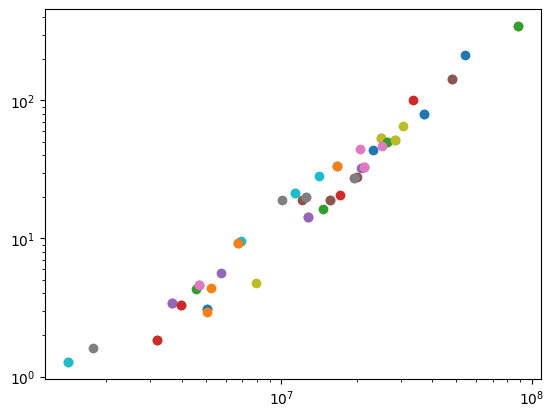

In [35]:
Rr = 0.05
Q = np.zeros([n_sim])
Q_poi = np.zeros([n_sim])

for Q_bef,cave,diameter,area,i in zip(max_Q_nopipe,cave_height,breach_diameter,Areas,range(n_sim)):
        V_out = np.sqrt(2*g*cave)
        Q[i] = np.copy(Q_bef)
        Q_old = 0
        while(abs(Q[i] - Q_old)>0.00001):
            Q_old = np.copy(Q[i])
            
            Re2 = reynolds_ph(diameter/2,Q[i])
            plt.scatter(Re2,Q[i])
            plt.xscale('log')
            plt.yscale('log')

            lamda = Churchill(Re2,Rr)
            
            Q[i] = Darcy_Weisbach(cave,20,lamda,diameter)
            Q_poi[i] = Poiseuille(cave,20,diameter)


In [36]:
print('Lambda with itterative solver, calulated flow is')
Darcy_Weisbach(5.5,2,lamda,0.6)

Lambda with itterative solver, calulated flow is


6.014471149805365

In [37]:
L2 = (1/(-2 * np.log10(Rr/3.7)))**2
print('Lambda with Eq. De Kármán, calulated flow is')

Darcy_Weisbach(5.5,2,L2,0.95)

Lambda with Eq. De Kármán, calulated flow is


18.971771305225353

In [43]:
# Calculate flow using Darcy-Weisbach with current lambda
result_lamda = Darcy_Weisbach(cave,2,lamda,diameter)
print("Darcy-Weisbach with lambda:", result_lamda)

# Calculate flow using Darcy-Weisbach with L2 (De Kármán equation)
result_L2 = Darcy_Weisbach(cave,2,L2,diameter)
print("Darcy-Weisbach with L2:", result_L2)

Darcy-Weisbach with lambda: 4.036782807855979
Darcy-Weisbach with L2: 4.036592706094271


Text(0.5, 1.0, '2m Pipe')

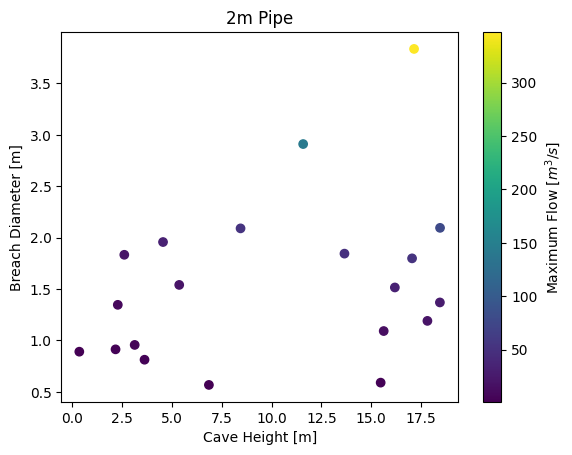

In [44]:
plt.scatter(cave_height,breach_diameter,c=Q)
plt.xlabel('Cave Height [m]')
plt.ylabel('Breach Diameter [m]')
cbar = plt.colorbar()
cbar.ax.set_ylabel('Maximum Flow [$m^{3} / s$]')
plt.title('2m Pipe')


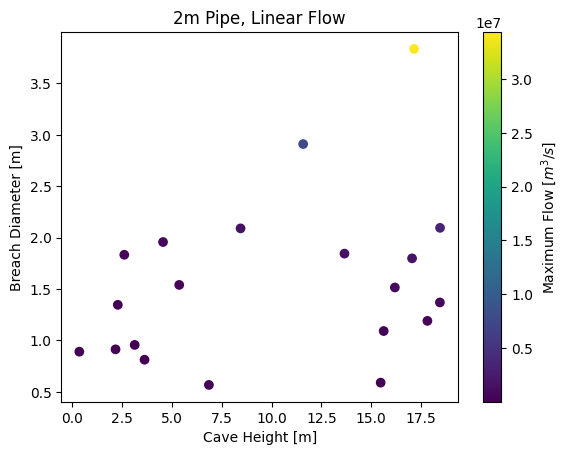

In [45]:
plt.scatter(cave_height,breach_diameter,c=Q_poi)
plt.xlabel('Cave Height [m]')
plt.ylabel('Breach Diameter [m]')
cbar = plt.colorbar()
cbar.ax.set_ylabel('Maximum Flow [$m^{3} / s$]')
plt.title('2m Pipe, Linear Flow')
plt.show()

In [48]:
cave_height_theo,breach_diameter_theo = np.meshgrid(np.arange(0.1,cave_max_height,0.1),np.arange(breach_bounds[0],breach_bounds[1],0.01))
Area_theo = math.pi * np.power(breach_diameter_theo/2,2)
g = 9.81
max_Q_theo = Area_theo*np.sqrt(2*g*cave_height_theo)

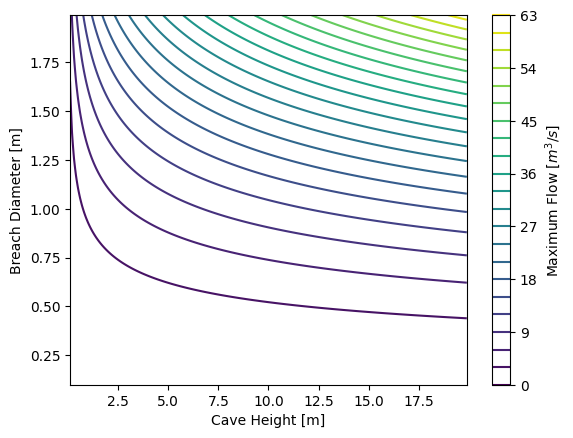

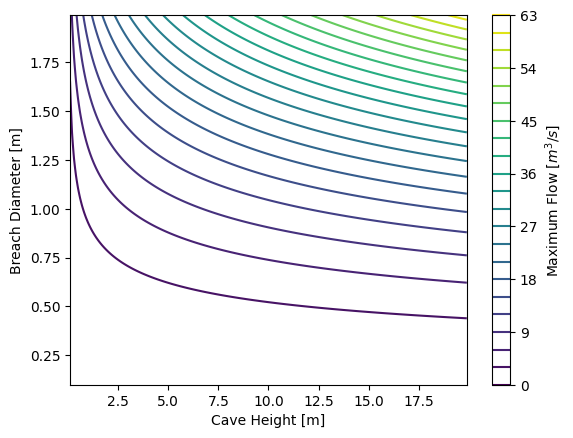

In [51]:
plt.contour(cave_height_theo,breach_diameter_theo,max_Q_theo,20)
plt.xlabel('Cave Height [m]')
plt.ylabel('Breach Diameter [m]')
cbar = plt.colorbar()
cbar.ax.set_ylabel('Maximum Flow [$m^{3} / s$]')
plt.show(())

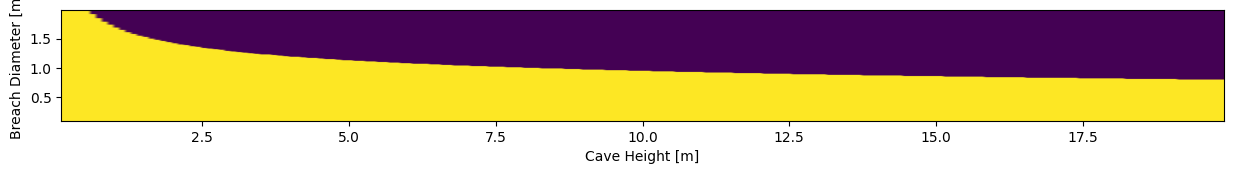

In [52]:
plt.figure(figsize=[15,15])
bo_10 = np.copy(max_Q_theo)
bo_10[bo_10 < 10] = 1
bo_10[bo_10 > 10] = 0
plt.imshow(bo_10, extent=[cave_height_theo[0][0],cave_height_theo[-1][-1],breach_diameter_theo[-1][-1],breach_diameter_theo[0][0]])
plt.xlabel('Cave Height [m]')
plt.ylabel('Breach Diameter [m]')
plt.gca().invert_yaxis()


## Time Dependant test


In [60]:
class ProgressBar:
    '''
    Progress bar
    '''
    def __init__ (self, valmax, maxbar, title):
        if valmax == 0:  valmax = 1
        if maxbar > 200: maxbar = 200
        self.valmax = valmax
        self.maxbar = maxbar
        self.title  = title
    
    def update(self, val):
        import sys
        # format
        if val > self.valmax: val = self.valmax
        
        # process
        perc  = round((float(val) / float(self.valmax)) * 100)
        scale = 100.0 / float(self.maxbar)
        bar   = int(perc / scale)
  
        # render 
        out = '\r %20s [%s%s] %3d %%' % (self.title, '=' * bar, ' ' * (self.maxbar - bar), perc)
        sys.stdout.write(out)

In [61]:
n_sim = 100
cave_max_height = 30
breach_bounds = [0.1,2]

In [73]:
cave_height     = np.random.random((n_sim,)) * cave_max_height #will implement ditrib
breach_diameter = np.random.random((n_sim,)) * (breach_bounds[1]-breach_bounds[0]) + breach_bounds[0] #will implement ditrib

it = 1000
dt = 0.1
res_Q = np.zeros((n_sim,it))
res_h = np.zeros((n_sim,it))
Bar = ProgressBar(n_sim, 60, 'Simulating in progress...')

# Simulate cave emptying for each scenario
for cave, breach, sim in zip(cave_height, breach_diameter, range(n_sim)):
    # Estimate cave section (randomized, proportional to cave height)
    cave_section = np.power(np.random.random((1,)) * cave / 2, 2)
    Area = math.pi * np.power(breach / 2, 2)
    g = 9.81
    Bar.update(sim)  # Update progress bar

    # Time-stepping simulation
    for i in np.arange(0, it):
        dQdt = Area * np.sqrt(2 * g * cave)  # Instantaneous outflow rate
        Q = dQdt * dt                        # Outflow volume for this step
        dh = Q / cave_section                # Water level drop
        cave = cave - dh                     # Update cave water height

        res_Q[sim][i] = dQdt                 # Store flow rate
        res_h[sim][i] = cave                 # Store water height

        if cave <= 0:                        # Stop if cave is empty
            break

 Simulating in progress... [======================================                      ]  64 %

/tmp/ipykernel_130967/4226446631.py:26: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  res_h[sim][i] = cave                 # Store water height
/tmp/ipykernel_130967/4226446631.py:25: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  res_Q[sim][i] = dQdt                 # Store flow rate


 Simulating in progress... [=========================================================== ]  99 %

In [63]:
res_Q[res_Q < 0] = np.nan
res_h[res_h < 0] = np.nan
t_vector = np.arange(0,it*dt,dt)

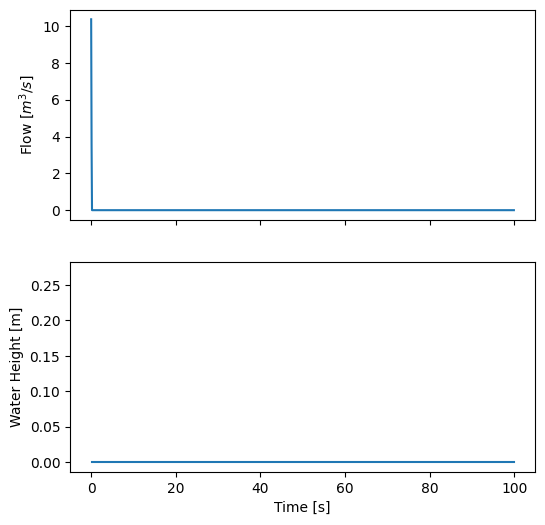

In [68]:
fig, axs = plt.subplots(2,1,sharex=True,figsize=[6,6],)

axs[0].plot(t_vector,res_Q[0])
axs[0].set_ylabel('Flow [$m^3/s$]')
#plt.text(10,10,'cave_height : ' + str(cave_height[0])+' and breach_diameter : ' + str(breach_diameter[0]) )

axs[1].plot(t_vector,res_h[0])
axs[1].set_xlabel('Time [s]')
axs[1].set_ylabel('Water Height [m]')
plt.show()

In [72]:
Mean_Q = np.nanmean(res_Q,axis=0)
STD_Q  = np.nanstd(res_Q,axis=0)
print('Mean Flow : ' + str(Mean_Q[0]) + ' m^3/s')

Mean Flow : 17.075393885581644 m^3/s


Text(0.5, 1.0, 'Mean flow over100 Simus')

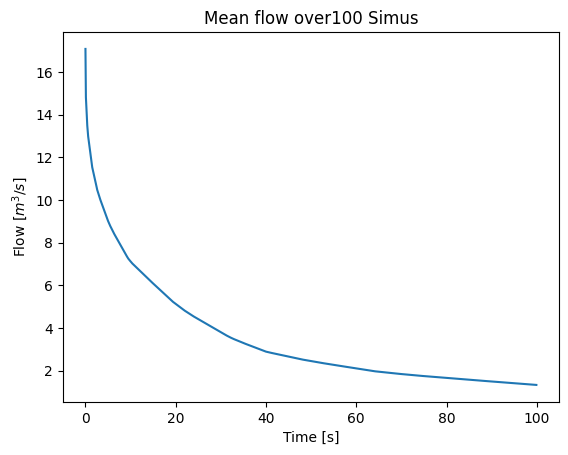

In [74]:
plt.plot(t_vector,Mean_Q)
plt.ylabel('Flow [$m^3/s$]')
plt.xlabel('Time [s]')
plt.title('Mean flow over' + str(n_sim) + ' Simus')

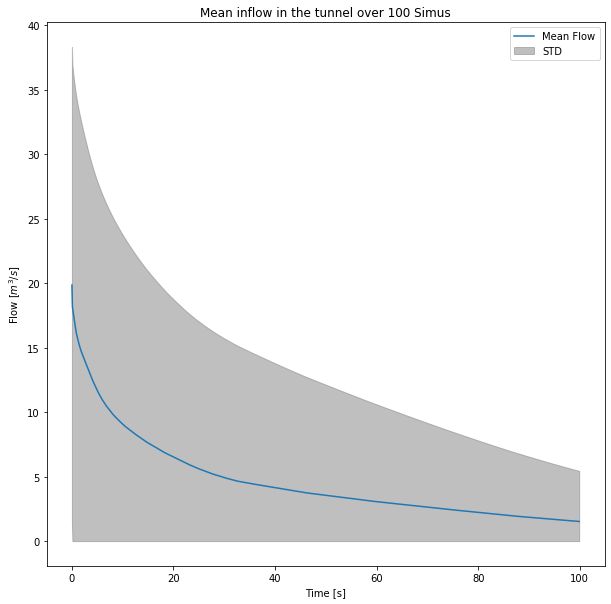

In [428]:
plt.figure(figsize=[10,10])
low_std = Mean_Q-STD_Q
low_std[low_std < 0] = 0
high_std = Mean_Q+STD_Q
plt.fill_between(t_vector,high_std,low_std,alpha=0.5,color='grey')
plt.plot(t_vector,Mean_Q)
plt.ylabel('Flow [$m^3/s$]')
plt.xlabel('Time [s]')
plt.title('Mean inflow in the tunnel over ' + str(n_sim) + ' Simus')
plt.legend(['Mean Flow','STD'])

Text(0.5, 1.0, 'Parameters over 100 Simus')

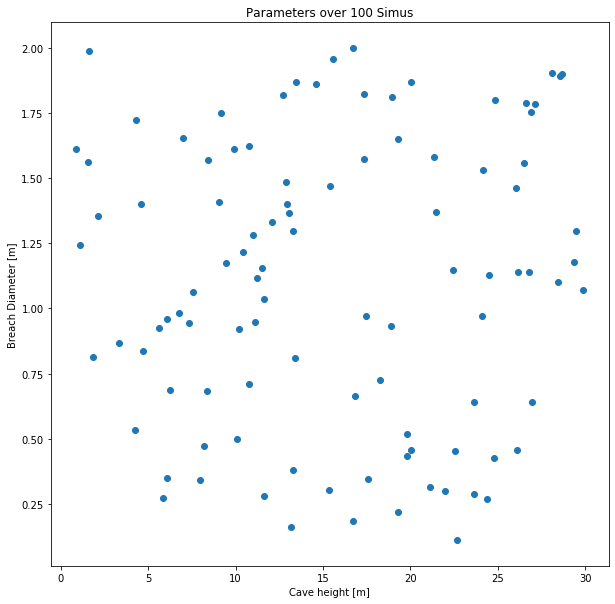

In [429]:
plt.figure(figsize=[10,10])
plt.scatter(cave_height,breach_diameter)
plt.xlabel('Cave height [m]')
plt.ylabel('Breach Diameter [m]')
plt.title('Parameters over ' + str(n_sim) + ' Simus')


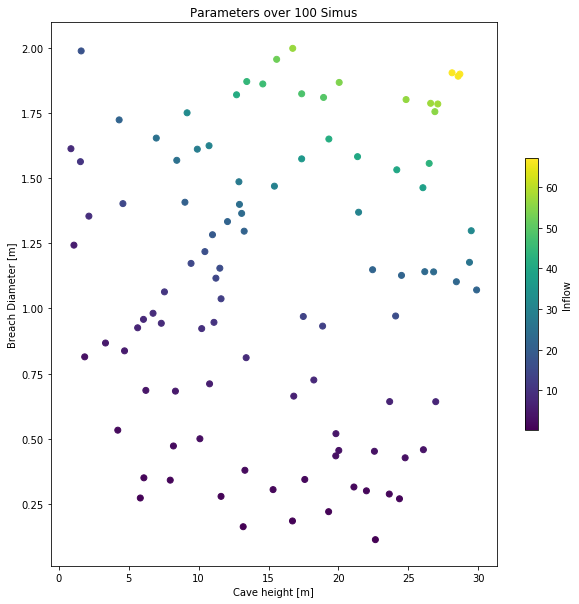

In [430]:
plt.figure(figsize=[10,10])
plt.scatter(cave_height,breach_diameter,c=res_Q[:,0])
plt.xlabel('Cave height [m]')
plt.ylabel('Breach Diameter [m]')
plt.title('Parameters over ' + str(n_sim) + ' Simus')
cbar = plt.colorbar(shrink=.5)
cbar.set_label('Inflow')
